# 03_data_visualization
Dieses Notebook ist für die Visualisierung der Auswertungen.

In [31]:

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy.stats import pearsonr

project_root = Path('..').resolve()
output_dir = project_root / 'work/output'
processed_dir = output_dir / 'processed'
maps_dir = output_dir / 'maps'
figures_dir = output_dir / 'figures'

merged = pd.read_csv(processed_dir / 'merged_energy_wealth.csv')
geo_path = processed_dir / 'zh_municipalities.geojson'
geo = gpd.read_file(geo_path) if geo_path.exists() else None

maps_dir.mkdir(parents=True, exist_ok=True)
figures_dir.mkdir(parents=True, exist_ok=True)

print('Data for visualization loaded:', merged.shape, 'geo' if geo is not None else 'no geo')

Data for visualization loaded: (160, 10) geo


In [ ]:
# Choroplethenkarten erstellen mit Gemeindenamen
import matplotlib.patheffects as patheffects

vars_to_map = ['household_elec_per_capita_mwh_2024', 'total_elec_per_capita_mwh_2024',
               'income_median_2022', 'income_avg_2022', 'capital_median_2022', 'capital_avg_2022']

if geo is not None:
    # Ensure bfs_nr has the same type in both dataframes
    geo['bfs_nr'] = geo['bfs_nr'].astype(int)
    merged_geo = geo.merge(merged, on='bfs_nr', how='inner')
    
    # Berechne repräsentative Punkte für Label-Positionierung (einmal für alle Karten)
    if 'rep_point' not in merged_geo.columns:
        merged_geo['rep_point'] = merged_geo.geometry.representative_point()
    
    # Optional: Fläche berechnen, um nur größere Gemeinden zu beschriften
    try:
        merged_geo_proj = merged_geo.to_crs(epsg=3857)
        merged_geo['area_m2'] = merged_geo_proj.geometry.area
    except Exception:
        merged_geo['area_m2'] = 0
    
    # Konfiguration: Beschriftung nur für Gemeinden >= threshold (in m²)
    # Setze threshold = 0 um alle Gemeinden zu beschriften (kann überfüllt sein)
    label_threshold = 5e6  # ~5 km² - passe nach Bedarf an
    
    for var in vars_to_map:
        if var not in merged_geo.columns:
            continue
        fig, ax = plt.subplots(figsize=(10, 10))
        merged_geo.plot(column=var, cmap='viridis', linewidth=0.5, edgecolor='white',
                        legend=True, legend_kwds={'label': var}, ax=ax)
        
        # Füge Gemeindenamen hinzu
        for idx, row in merged_geo.iterrows():
            # Überspringe kleine Gemeinden (falls threshold > 0)
            if row.get('area_m2', 0) < label_threshold:
                continue
            
            name = row.get('municipality') or row.get('name') or ''
            if not name:
                continue
            
            pt = row['rep_point']
            x, y = pt.x, pt.y
            
            # Text mit weißem Rand für bessere Lesbarkeit
            txt = ax.text(x, y, name, fontsize=7, ha='center', va='center', 
                         color='black', weight='bold')
            txt.set_path_effects([patheffects.withStroke(linewidth=2, foreground='white')])
        
        ax.axis('off')
        plt.title(f'Zurich municipalities: {var}', fontsize=12, pad=12)
        plt.tight_layout()
        plt.savefig(maps_dir / f'{var}.png', dpi=150, bbox_inches='tight')
        plt.close()
    print(f"Saved {len(vars_to_map)} choropleth maps with labels.")
else:
    print('GeoJSON not available; skipping maps.')


Saved 6 choropleth maps.


In [5]:
# Scatterplots für jede Energie-/Vermögenskombination
energy_cols = ['household_elec_per_capita_mwh_2024', 'total_elec_per_capita_mwh_2024']
wealth_cols = [
    'income_median_2022','income_avg_2022','income_total_per_capita_2022',
    'capital_median_2022','capital_avg_2022','capital_total_per_capita_2022'
]
energy_labels = {
    'household_elec_per_capita_mwh_2024': 'Household Electricity (MWh/capita)',
    'total_elec_per_capita_mwh_2024': 'Total Electricity (MWh/capita)'
}
wealth_labels = {
    'income_median_2022': 'Median Income (CHF)',
    'income_avg_2022': 'Average Income (CHF)',
    'income_total_per_capita_2022': 'Income per Capita (CHF)',
    'capital_median_2022': 'Median Capital (CHF)',
    'capital_avg_2022': 'Average Capital (CHF)',
    'capital_total_per_capita_2022': 'Capital per Capita (CHF)'
}

sns.set_context('notebook')
sns.set_style('whitegrid')

for energy_col in energy_cols:
    if energy_col not in merged.columns:
        continue
    for wealth_col in wealth_cols:
        if wealth_col not in merged.columns:
            continue
        df = merged[[energy_col, wealth_col]].dropna()
        if df.empty:
            continue
        pr, _ = pearsonr(df[energy_col], df[wealth_col])
        plt.figure(figsize=(8, 6))
        sns.regplot(data=df, x=energy_col, y=wealth_col,
                    scatter_kws={'alpha':0.6, 's':50},
                    line_kws={'color': 'red', 'alpha': 0.7})
        plt.xlabel(energy_labels.get(energy_col, energy_col))
        plt.ylabel(wealth_labels.get(wealth_col, wealth_col))
        plt.title(f'{wealth_labels.get(wealth_col, wealth_col)} vs {energy_labels.get(energy_col, energy_col)}Pearson r = {pr:.3f}')
        plt.tight_layout()
        plt.savefig(figures_dir / f'scatter_{energy_col}_{wealth_col}.png', dpi=150)
        plt.close()
print('Scatter plots saved.')

Scatter plots saved.


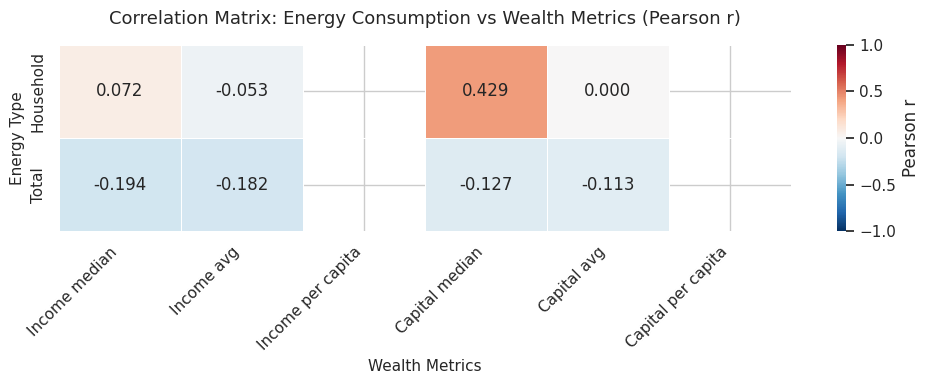

Correlation heatmap saved.


In [6]:
# Pearson-Korrelations-Heatmap
energy_labels_short = ['Household', 'Total']
energy_cols_short = ['household_elec_per_capita_mwh_2024', 'total_elec_per_capita_mwh_2024']
wealth_labels_short = ['Income median', 'Income avg', 'Income per capita', 'Capital median', 'Capital avg', 'Capital per capita']
wealth_cols_short = [
    'income_median_2022','income_avg_2022','income_total_per_capita_2022',
    'capital_median_2022','capital_avg_2022','capital_total_per_capita_2022'
]

corr_matrix = []
for e_col in energy_cols_short:
    row = []
    if e_col not in merged.columns:
        row = [np.nan]*len(wealth_cols_short)
    else:
        for w_col in wealth_cols_short:
            if w_col not in merged.columns:
                row.append(np.nan)
                continue
            df = merged[[e_col, w_col]].dropna()
            if df.empty:
                row.append(np.nan)
                continue
            pr, _ = pearsonr(df[e_col], df[w_col])
            row.append(pr)
    corr_matrix.append(row)

fig, ax = plt.subplots(figsize=(10, 4))
corr_df_heatmap = pd.DataFrame(corr_matrix, index=energy_labels_short, columns=wealth_labels_short)
sns.heatmap(corr_df_heatmap, annot=True, fmt='.3f', cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            cbar_kws={'label': 'Pearson r'}, linewidths=0.5, ax=ax)
plt.title('Correlation Matrix: Energy Consumption vs Wealth Metrics (Pearson r)', fontsize=13, pad=15)
plt.xlabel('Wealth Metrics', fontsize=11)
plt.ylabel('Energy Type', fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(figures_dir / 'correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print('Correlation heatmap saved.')

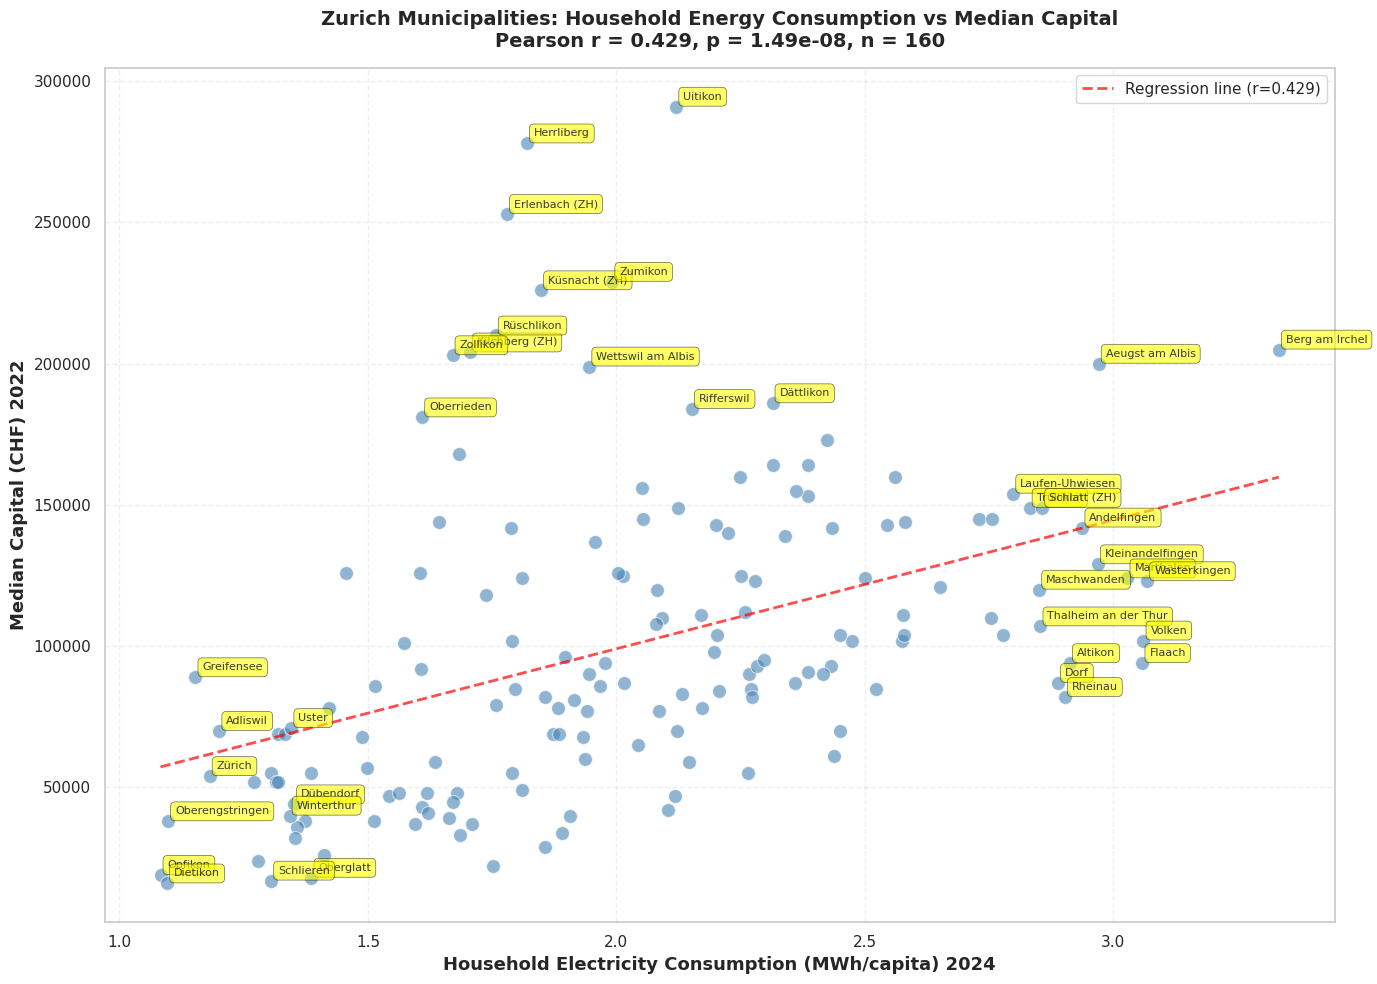

Scatter plot saved with 39 municipalities labeled (outliers and major cities).


In [7]:
# Hervorgehobener Scatterplot Haushaltsenergie vs. Medianvermögen
if 'household_elec_per_capita_mwh_2024' in merged.columns and 'capital_median_2022' in merged.columns:
    df_plot = merged[['bfs_nr', 'municipality', 'household_elec_per_capita_mwh_2024', 'capital_median_2022']].dropna()
    if not df_plot.empty:
        fig, ax = plt.subplots(figsize=(14, 10))
        scatter = ax.scatter(df_plot['household_elec_per_capita_mwh_2024'],
                            df_plot['capital_median_2022'],
                            alpha=0.6, s=100, c='steelblue', edgecolors='white', linewidth=0.8)
        energy_mean = df_plot['household_elec_per_capita_mwh_2024'].mean()
        energy_std = df_plot['household_elec_per_capita_mwh_2024'].std()
        capital_mean = df_plot['capital_median_2022'].mean()
        capital_std = df_plot['capital_median_2022'].std()

        labeled_count = 0
        for _, row in df_plot.iterrows():
            energy_z = abs((row['household_elec_per_capita_mwh_2024'] - energy_mean) / energy_std)
            capital_z = abs((row['capital_median_2022'] - capital_mean) / capital_std)
            if energy_z > 1.5 or capital_z > 1.5 or row['municipality'] in ['Zürich', 'Winterthur', 'Uster', 'Dübendorf', 'Dietikon']:
                ax.annotate(text=row['municipality'],
                           xy=(row['household_elec_per_capita_mwh_2024'], row['capital_median_2022']),
                           xytext=(5, 5), textcoords='offset points',
                           fontsize=8, alpha=0.9,
                           bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.6, edgecolor='black', linewidth=0.5))
                labeled_count += 1

        from scipy.stats import linregress
        slope, intercept, r_value, p_value, _ = linregress(df_plot['household_elec_per_capita_mwh_2024'], df_plot['capital_median_2022'])
        x_line = np.linspace(df_plot['household_elec_per_capita_mwh_2024'].min(),
                            df_plot['household_elec_per_capita_mwh_2024'].max(), 100)
        y_line = slope * x_line + intercept
        ax.plot(x_line, y_line, 'r--', linewidth=2, alpha=0.7, label=f'Regression line (r={r_value:.3f})')

        ax.set_xlabel('Household Electricity Consumption (MWh/capita) 2024', fontsize=13, fontweight='bold')
        ax.set_ylabel('Median Capital (CHF) 2022', fontsize=13, fontweight='bold')
        ax.set_title('Zurich Municipalities: Household Energy Consumption vs Median Capital\n'
                    f'Pearson r = {r_value:.3f}, p = {p_value:.2e}, n = {len(df_plot)}',
                    fontsize=14, pad=15, fontweight='bold')
        ax.legend(fontsize=11, loc='best')
        ax.grid(True, alpha=0.3, linestyle='--')
        plt.tight_layout()
        plt.savefig(figures_dir / 'household_energy_vs_median_capital.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f'Scatter plot saved with {labeled_count} municipalities labeled (outliers and major cities).')
    else:
        print('No data available for scatter plot.')
else:
    print('Required columns not found in merged data.')
